# Problema de llenado de tanques. Bertsekas Vol1 - pag 143
---
## Descripcion

Se plantea el problema de controlar el flujo de entrada al tanque 1 de manera de lograr que arrancando en $t=0$ con ambos tanques vacios, alcancemos el tiempo $t=1$ con el tanque 1 en cota $x_1=0.5$ y el tanque 2 en una cota lo  maxima posible.
<img src="Reservoirs_Original.png">

El sistema dinamico es:

$$\left\{
\begin{eqnarray} 
    \dot{x}_1 &=& u - x_1 \\
    \dot{x}_2 &=& x_1
\end{eqnarray}
\right.$$

Con condiciones inciales $x_1(0)=0$ y $x_2(0)=0$.

Se busca controlar el caudal de entrada ($u$) sujeto a que $|u|\leq 1$, de tal forma que $x_1(1)=0.5$ y se maximice $x_2(1)$.

# Solución Numérica de Descarga de Tanques Modificada
---
## Descripción de Modificación
Se modifica la ley de descarga del tanque número 1. En el problema original el caudal (velocidad) de descarga se toma proporcional a la altura de agua acumulada en dicho tanque.

Usando la ley de Bernoulli:

$$\left( p + \frac{1}{2}\rho v^2 + \rho g h\right)_A = \left( p + \frac{1}{2}\rho v^2 + \rho g h\right)_B$$

Tomaremos el punto $A$ en la superficie libre de agua y el punto $B$ en la descarga del tanque. Las presiones en ambos puntos son atmosfericas y la velocidad de ascenso o descenso de la superficie libre se puede despreciar frente a la velocidad de descarga. Bajo las hipotesis anteriores, podemos relacionar la velocidad del flujo de descarga con la cota del tanque 1.

$$v_B = \sqrt{2g\Delta h}$$

Dado que en el ejercicio se desprecian las constantes fisicas ($\rho$,$g$), asumimos la siguiente dinamica para el modelo hidraulico de los tanques en serie:


$$\left\{
\begin{eqnarray} 
    \dot{x}_1 &=& u - \alpha \sqrt{x_1} \\
    \dot{x}_2 &=& \sqrt{x_1}
\end{eqnarray}
\right.$$

Incluimos una constante $\alpha$ para regular la velocidad de descarga.


In [1]:
using JuMP, Ipopt

In [2]:
# Codigo basado en ejemplo "Rocket Control" (https://www.juliaopt.org/notebooks/JuMP-Rocket.html)

# Creo el modelo usando JuMP, uso Ipopt como solver, el problema tiene restricciones NonLin
mod = Model(with_optimizer(Ipopt.Optimizer,print_level=0))

# Ejemplo de llenado de un tanque a traves de vaciado de otro
# de manera de llegar a t=1 con el primer tanque 50% lleno y el segundo con cota maxima.

x1_0 = 0    # Cota Tanque 1 Inicial
x2_0 = 0    # Cota Tanque 2 Inicial

n = 100                                    # Numero de Pasos Temporales
t_f = 1                                    # Tiempo Final
Δt = 1/n                                   # Intervalo de Tiempo

# Variables Dinamicas
@variable(mod, x1[0:n] >= 0 )          # Cota Tanque 1
@variable(mod, x2[0:n] >= 0 )          # Cota Tanque 2

# Control: Caudal de llenado en Tanque 1
@variable(mod, 0 ≤ u[0:n] ≤ 1)

# Objetivo: Maximizar cota tanque 2 en t=1
@NLobjective(mod, Max, x2[n] )

# Condiciones Iniciales
@constraint(mod, x1[0] == x1_0)
@constraint(mod, x2[0] == x2_0)

# Condiciones Finales
@constraint(mod, x1[n] == 0.5)

# Parametros Propio y Auxiliar de la Dinamica

α = 0.5     # Probar con 0.5, 0.75 y 0.9. Vemos que con 1.0 la ley sqrt(x1) vacia demasiado rapido y no hay solucion.
ϵ = 1e-8 # usamos este parametro para evitar la sigularidad de la derivada de sqrt(x1)

# Dinamica
for j in 1:n
    # x1' = -α*sqrt(x1+ϵ)+u
    # Regla del Trapecio
    @NLconstraint(mod,
    x1[j] == x1[j-1] + 0.5*Δt*(-α*(x1[j]+ϵ)^0.5+u[j]-α*(x1[j-1]+ϵ)^0.5+u[j-1]))

    # x2' = α*sqrt(x1+ϵ)
    # Regla del Trapecio
    @NLconstraint(mod,
    x2[j] == x2[j-1] + 0.5*Δt*(α*(x1[j]+ϵ)^0.5+α*(x1[j-1]+ϵ)^0.5))
end

# Punto de arranque para Ipopt
for k in 0:n
    set_start_value(x1[k],0.5*(k/n)^2)
    set_start_value(x2[k], 0.3*k/n)
    set_start_value(u[k], .6)
end

# Imprimo Problema de Optimizacion (mod)
#print(mod)
println("")

# Resolvemos variables de estado y de control
println("Solving...")
status = optimize!(mod)

# Mostramos resultados
println("Estado del Solver: ", JuMP.termination_status(mod))
println("Cota Maxima En Tanque 2 @(t=1): ", JuMP.objective_value(mod))


Solving...

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Estado del Solver: LOCALLY_SOLVED
Cota Maxima En Tanque 2 @(t=1): 0.28578868435571175


## Presentacion de Resultados

Graficamos a continuacion la evolucion en el tiempo de las cotas en los tanques 1 y 2, asi como la variable de control $u$.

In [3]:
using Gadfly

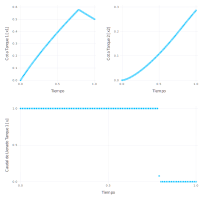

In [4]:
tiempo = collect((0:n)*Δt)

collect(value.(x1))

x1_plot = plot(x=tiempo,y=collect(value.(x1)), Gadfly.Geom.point,
Gadfly.Guide.xlabel("Tiempo"), Gadfly.Guide.ylabel("Cota Tanque 1 [x1]"))

x2_plot = plot(x=tiempo,y=collect(value.(x2)), Gadfly.Geom.point,
Gadfly.Guide.xlabel("Tiempo"), Gadfly.Guide.ylabel("Cota Tanque 2 [x2]"))

u_plot = plot(x=tiempo,y=collect(value.(u)), Gadfly.Geom.point,
Gadfly.Guide.xlabel("Tiempo"), Gadfly.Guide.ylabel("Caudal de Llenado Tanque 1 [u]"))

draw(SVG(8inch, 8inch), vstack(hstack(x1_plot,x2_plot),u_plot)) 

A partir de la solución numérica del problema, podemos encontrar el tiempo en el cual debemos switchear de caudal máximo a cero caudal ($\hat{t}$) y la cota del tanque 1 en ese instante ($\hat{x}_1$). 

La solución analítica usando el Principio del Minimo de Pontryagin obtenemos el tiempo de switcheo y la cota a partir de la siguientes ecuaciones:

$$\ln{\left(\frac{2}{2-\sqrt{\hat{x}_1}}\right)}=\sqrt{1/8}+1/8$$

$$\hat{t}=-4 \sqrt{\hat{x}_1}+\sqrt{8}+1$$

De donde podemos obtener que: $\hat{x}_1=0.578575$ y $\hat{t}=0.78586$.

La solución numérica de estos valores son:

In [5]:
x_tilde = maximum(value.(x1))

0.5766042427857783

In [6]:
t_tilde = sum(value.(u))/n

0.7907887119699423